In [126]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import src as functions
%load_ext autoreload 
%autoreload 2
import re
from nltk.tokenize import regexp_tokenize, word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split, cross_validate , GridSearchCV, cross_val_predict
from sklearn.pipeline import make_pipeline , Pipeline
from nltk import word_tokenize
from nltk.corpus import stopwords as sw
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as imbpipe
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings ("ignore")
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from nltk.stem import SnowballStemmer
from sklearn.cluster import KMeans
from sklearn.metrics import plot_confusion_matrix , fbeta_score, make_scorer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
def transform(df,review_col):
    '''Returns a DataFrame transformed and ready to be tested. Returns the df with 
    Tokens, Number of words, Char Review Count, Sentences and Sentence Count'''
    df_engineered = df.copy()
    # Make a column to split words up, puncuation is included
    df_engineered['Tokens'] = df[review_col].str.split(' ')
    # Find the number of words in each review
    df_engineered['Number of Words'] = df_engineered['Tokens'].map(lambda x: len(x))
    # Find number of characters used in Reviews
    df_engineered['Character Review Length'] = df_engineered[review_col].map(lambda x: len(x))
    # Find Number of Sentences in Each Review
    df_engineered['Sentences'] = df_engineered[review_col].map(lambda x:sent_tokenize(x))
    df_engineered['Sentence Count'] = df_engineered['Sentences'].map(lambda x : len(x))
    df_engineered['Avg Words Per Sentence'] = df_engineered['Number of Words'] / df_engineered['Sentence Count']
    return df_engineered

def test_df(df,review_col):
    X = df.copy()
    X = df[[review_col,'Number of Words','Character Review Length','Sentence Count','Avg Words Per Sentence']]
    # Remove all numbers
    X[review_col] = X[review_col].str.replace('\d+', '')
    # Make a tokenize column
    X['token'] = X[review_col].map(lambda x: word_tokenize(x))
    # Stem words in the tokenized column then create a column where they are joined
    X['stem'] = X['token'].apply(lambda x: [SnowballStemmer('english').stem(y) for y in x])
    X['sentence'] = X['stem'].apply(lambda x : ' '.join(x))
    # Add all of our extra features in
    X = X[['sentence','Number of Words','Character Review Length','Sentence Count','Avg Words Per Sentence']]
    return X

In [128]:
# Load our Test DF into our notebook
df  = pd.read_csv('data/Labelled Yelp Dataset Edited.csv')

df_test = transform(df,'Review')


# TFIDF Multinomial Model

In [129]:
# Relabel our targets to a traditional 0 1 label
binary_dict = {1:0,-1:1}
df_test['Label'] = df_test['Label'].map(binary_dict)

In [130]:
#This takes out the puncuation and makes everything lower cased. Numbers are still included in this model.
df_test['Test Column'] = df_test['Review'].str.replace(r'[^\w\s]', '')
df_test['Test Column'] = df_test['Test Column'].str.lower()

In [131]:
X = df_test['Test Column']
y = df_test['Label']

In [132]:
#Perform train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [133]:
#Create pipeline and cross validate
first_model = make_pipeline(TfidfVectorizer(stop_words=sw.words('english')), MultinomialNB())
first_model_results = cross_validate(first_model, X_train, y_train,return_train_score=True)

In [134]:
functions.mean_scores(first_model_results)

Mean Train Score: 0.9005521894667872
Mean Test Score: 0.9003196246246615


In [135]:
y_preds = cross_val_predict(first_model, X_train, y_train)
functions.metrics(y_train,y_preds)

Recall Score: 0.0010756543564001434
Precision Score: 1.0
Accuracy Score:0.9003196259898865
F1 Score: 0.002148997134670487
Confusion Matrix: 
[[75481     0]
 [ 8358     9]]


As we can see, the simple model has a hard time catching the fake reviews. This has no stemming or over/under sampling techniques. Future iterations will experiment with these along with other features that have been engineered. Also the matrics I am thinking about are either F1 or Recall. This is because I intend this system to flag reviews for a person to look at. This would mean it is okay to have more false positives because the reviews will be peer reviewed.

# TFIDF Logistic Model

In [136]:
second_model = make_pipeline(TfidfVectorizer(stop_words=sw.words('english')),LogisticRegression())
second_results = cross_validate(second_model,X_train,y_train,return_train_score=True)

In [137]:
functions.mean_scores(second_results)

Mean Train Score: 0.9009815384159419
Mean Test Score: 0.8996159757976898


In [138]:
y_preds_LR = cross_val_predict(second_model, X_train, y_train)
functions.metrics(y_train,y_preds_LR)

Recall Score: 0.007768614796223258
Precision Score: 0.3611111111111111
Accuracy Score:0.89961597175842
F1 Score: 0.01521001521001521
Confusion Matrix: 
[[75366   115]
 [ 8302    65]]


So this is an improvement, this is picking up more on the fake reviews than the NB model did. This is a good step in the right direction.

# XGBoost TFIDF Model

In [139]:
xg_model = make_pipeline(TfidfVectorizer(stop_words=sw.words('english')),XGBClassifier())
xg_results = cross_validate(xg_model,X_train,y_train,return_train_score=True)

In [140]:
functions.mean_scores(xg_results)

Mean Train Score: 0.9062052780226235
Mean Test Score: 0.8997113878211751


In [141]:
xg_preds = cross_val_predict(xg_model,X_train,y_train)
functions.metrics(y_train,xg_preds)

Recall Score: 0.006214891836978606
Precision Score: 0.3561643835616438
Accuracy Score:0.8997113825016697
F1 Score: 0.012216609890755315
Confusion Matrix: 
[[75387    94]
 [ 8315    52]]


Similar to the Logistic model, less positives but less FP also. Right now the LR model is the best.

# Oversampling

# Logistic Regression with TFIDF

In [142]:
imb_log_model = imbpipe(steps=[
                         ('tfid',TfidfVectorizer(stop_words=sw.words('english'))),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('LR',LogisticRegression(C=.1))])

imb_log_results = cross_validate(imb_log_model,X_train,y_train,return_train_score=True)
functions.mean_scores(imb_log_results)

Mean Train Score: 0.7226827273824232
Mean Test Score: 0.7001956800984354


In [143]:
imb_log_preds = cross_val_predict(imb_log_model,X_train,y_train)
functions.metrics(y_train,imb_log_preds)

Recall Score: 0.6134815346002152
Precision Score: 0.18946552487819282
Accuracy Score:0.6995396431638202
F1 Score: 0.2895174708818636
Confusion Matrix: 
[[53522 21959]
 [ 3234  5133]]


This has by far been the best model yet.

# TFIDF Naive Bayes

In [144]:
imb_bayes_model = imbpipe(steps=[
                         ('tfid',TfidfVectorizer(stop_words=sw.words('english'))),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('bae',MultinomialNB())])

imb_bayes_results = cross_validate(imb_bayes_model,X_train,y_train,return_train_score=True)
functions.mean_scores(imb_bayes_results)

Mean Train Score: 0.8150075057186668
Mean Test Score: 0.7532559785955378


In [145]:
imb_bayes_preds = cross_val_predict(imb_bayes_model,X_train,y_train)
functions.metrics(y_train,imb_bayes_preds)

Recall Score: 0.4896617664634875
Precision Score: 0.19834430673896206
Accuracy Score:0.7515862036065261
F1 Score: 0.2823278089790856
Confusion Matrix: 
[[58922 16559]
 [ 4270  4097]]


About the same as the LR model, a little bit better.

# XGBoost with TFIDF

In [146]:
imb_boost_model = imbpipe(steps=[
                         ('tfid',TfidfVectorizer(stop_words=sw.words('english'))),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('boost',XGBClassifier())])

imb_boost_results = cross_validate(imb_boost_model,X_train,y_train,return_train_score=True)
functions.mean_scores(imb_boost_results)

Mean Train Score: 0.75429944063062
Mean Test Score: 0.6914297995637733


In [147]:
imb_boost_preds = cross_val_predict(imb_boost_model,X_train,y_train)
functions.metrics(y_train,imb_boost_preds)

Recall Score: 0.5628062626986973
Precision Score: 0.17629441054247313
Accuracy Score:0.6939700410266196
F1 Score: 0.26848737100176745
Confusion Matrix: 
[[53479 22002]
 [ 3658  4709]]


This model has the best detection of fake reviews while not predicting everything as fake.

# Undersampling

# LR Model

In [148]:
under_log_model = imbpipe(steps=[
                         ('tfid',TfidfVectorizer(stop_words=sw.words('english'))),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('LR',LogisticRegression())])

under_log_results = cross_validate(under_log_model,X_train,y_train,return_train_score=True)
functions.mean_scores(under_log_results)

Mean Train Score: 0.6697208128202929
Mean Test Score: 0.6484472693653809


In [149]:
under_log_preds = cross_val_predict(under_log_model,X_train,y_train)
functions.metrics(y_train,under_log_preds)

Recall Score: 0.6609298434325326
Precision Score: 0.17141971481711096
Accuracy Score:0.6473738192920523
F1 Score: 0.27223275161838184
Confusion Matrix: 
[[48751 26730]
 [ 2837  5530]]


# Naive Bayes

In [150]:
under_bayes_model = imbpipe(steps=[
                         ('tfid',TfidfVectorizer(stop_words=sw.words('english'))),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('bae',MultinomialNB())])

under_bayes_results = cross_validate(under_bayes_model,X_train,y_train,return_train_score=True)
functions.mean_scores(under_bayes_results)

Mean Train Score: 0.849274869551224
Mean Test Score: 0.8240507655090765


In [151]:
under_bayes_preds = cross_val_predict(under_bayes_model,X_train,y_train)
functions.metrics(y_train,under_bayes_preds)

Recall Score: 0.33034540456555517
Precision Score: 0.23025658113962014
Accuracy Score:0.8229772922431066
F1 Score: 0.27136615777330525
Confusion Matrix: 
[[66241  9240]
 [ 5603  2764]]


# XGBoost

In [152]:
under_boost_model = imbpipe(steps=[
                         ('tfid',TfidfVectorizer(stop_words=sw.words('english'))),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('boost',XGBClassifier())])

under_boost_results = cross_validate(under_boost_model,X_train,y_train,return_train_score=True)
functions.mean_scores(under_boost_results)

Mean Train Score: 0.6473738253538852
Mean Test Score: 0.6010281337702785


In [153]:
under_boost_preds = cross_val_predict(under_boost_model,X_train,y_train)
functions.metrics(y_train,under_boost_preds)

Recall Score: 0.6800525875463129
Precision Score: 0.15658539270185481
Accuracy Score:0.6025546226505104
F1 Score: 0.2545576557432055
Confusion Matrix: 
[[44833 30648]
 [ 2677  5690]]


The XGBoost model gives the highest recall score, but predicts a significant amount more of reviews being fake when they are real. The LR model comes close in recall, falling 1.5% behind the XGBoost while predicing less false positives. Hyperparameter tuning will be done for both to see which gives the best model.

# Hyperparameter Tuning

## LR Parameter Tuning

In [154]:
params = {'LR__C':[.1,1,20,50],
         'LR__solver':['lbfgs', 'liblinear', 'sag'],
         'LR__class_weight':[None,'balanced',.25]}

In [155]:
lr_gs = GridSearchCV(under_log_model,params,return_train_score=True,scoring='recall')

In [156]:
lr_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfid',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                     

In [157]:
lr_gs.best_params_

{'LR__C': 1, 'LR__class_weight': None, 'LR__solver': 'liblinear'}

In [158]:
lr_gs_ypreds = cross_val_predict(lr_gs.best_estimator_, X_train,y_train)

In [159]:
functions.metrics(y_train,lr_gs_ypreds)

Recall Score: 0.65853950041831
Precision Score: 0.17185989208072114
Accuracy Score:0.6492701078141399
F1 Score: 0.2725833580686653
Confusion Matrix: 
[[48930 26551]
 [ 2857  5510]]


In [160]:
xg_params = {'boost__n_estimators':[50,75,100],
            'boost__max_depth':[1,3,4,5],
            'boost__booster':['gbtree','dart'],
            'boost__eta':[.1,.3,.5,.7]}

## XGBoost GS

In [161]:
boost_gs = GridSearchCV(under_boost_model,xg_params,return_train_score=True,scoring='recall')
boost_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfid',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                     

In [162]:
boost_gs_ypreds = cross_val_predict(boost_gs.best_estimator_, X_train,y_train)
functions.metrics(y_train,boost_gs_ypreds)

Recall Score: 0.7417234373132544
Precision Score: 0.14948093552038924
Accuracy Score:0.5530960786184524
F1 Score: 0.2488172560339989
Confusion Matrix: 
[[40170 35311]
 [ 2161  6206]]


In [163]:
boost_gs.best_params_

{'boost__booster': 'gbtree',
 'boost__eta': 0.3,
 'boost__max_depth': 1,
 'boost__n_estimators': 50}

In [164]:
functions.metrics(y_train,boost_gs_ypreds)

Recall Score: 0.7417234373132544
Precision Score: 0.14948093552038924
Accuracy Score:0.5530960786184524
F1 Score: 0.2488172560339989
Confusion Matrix: 
[[40170 35311]
 [ 2161  6206]]


In [165]:
functions.metrics(y_train,lr_gs_ypreds)

Recall Score: 0.65853950041831
Precision Score: 0.17185989208072114
Accuracy Score:0.6492701078141399
F1 Score: 0.2725833580686653
Confusion Matrix: 
[[48930 26551]
 [ 2857  5510]]


# Unsupervised Learning - KMeans and TFIDF

In [166]:
knn = make_pipeline(TfidfVectorizer(stop_words=sw.words('english')),KMeans(n_clusters=2))


In [167]:
y_preds = cross_val_predict(knn,X_train,y_train)

In [168]:
functions.metrics(y_train,y_preds)

Recall Score: 0.4496235209752599
Precision Score: 0.09321340964840556
Accuracy Score:0.5086108195782845
F1 Score: 0.15441448097524937
Confusion Matrix: 
[[38884 36597]
 [ 4605  3762]]


There are models that do a better job of predicting fake than this one.

# Best Model with Engineered Features

In [169]:
X = df_test[['Test Column','Number of Words','Character Review Length','Sentence Count','Avg Words Per Sentence']]
y = df_test['Label']
# Remove all numbers
X['Test Column'] = X['Test Column'].str.replace('\d+', '')
# Make a tokenize column
X['token'] = X['Test Column'].map(lambda x: word_tokenize(x))

In [170]:
# Stem words in the tokenized column then create a column where they are joined
X['stem'] = X['token'].apply(lambda x: [SnowballStemmer('english').stem(y) for y in x])
X['sentence'] = X['stem'].apply(lambda x : ' '.join(x))

In [171]:
# Add all of our extra features in
X = X[['sentence','Number of Words','Character Review Length','Sentence Count','Avg Words Per Sentence']]
#Perform train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

# Logistic Regression

make_scorer(fbeta_score, beta=10)

In [173]:
# Tell TFIDF which column to vectorize
column_transformer = ColumnTransformer(
    [('tfidf1', TfidfVectorizer(stop_words=sw.words('english')), 'sentence')], 
    remainder='passthrough')

# fit the model
under_log_eng_model = imbpipe(steps=[('tfidf1', column_transformer),
                                     ('under',RandomUnderSampler('majority',random_state=42)),
                                     ('LR',LogisticRegression(C=.1,class_weight='balanced',solver='lbfgs',random_state=42))])
# Evaluate results     
under_log_eng_results = cross_validate(under_log_eng_model,X_train,y_train,return_train_score=True,scoring='recall')
functions.mean_scores(under_log_eng_results)

Mean Train Score: 0.7218239373655418
Mean Test Score: 0.704911015560226


In [174]:
# Metrics with confusion matrix
under_log_stem_preds = cross_val_predict(under_log_eng_model,X_train,y_train)
functions.metrics(y_train,under_log_stem_preds)

Recall Score: 0.7049121548942273
Precision Score: 0.16470719651484264
Accuracy Score:0.61382501669688
F1 Score: 0.26702281781963055
Confusion Matrix: 
[[45570 29911]
 [ 2469  5898]]


# XGBoost

In [175]:
# Tell TFIDF which column to vectorize
column_transformer = ColumnTransformer(
    [('tfidf1', TfidfVectorizer(stop_words=sw.words('english')), 'sentence')], 
    remainder='passthrough')

# fit the model
under_boost_eng_model = imbpipe(steps=[('tfidf1', column_transformer),
                                     ('under',RandomUnderSampler('majority',random_state=42)),
                                     ('boost',XGBClassifier(booster='dart',eta='.3',max_depth=1,n_estimators=75,random_state=42))])
# Evaluate results     
under_boost_eng_results = cross_validate(under_boost_eng_model,X_train,y_train,return_train_score=True,scoring='recall')
functions.mean_scores(under_boost_eng_results)

Mean Train Score: 0.7165054607351455
Mean Test Score: 0.7039530072462992


In [176]:
# Metrics with confusion matrix
under_boost_stem_preds = cross_val_predict(under_boost_eng_model,X_train,y_train)
functions.metrics(y_train,under_boost_stem_preds)

Recall Score: 0.7039560176885383
Precision Score: 0.1572721689674508
Accuracy Score:0.5940511401583818
F1 Score: 0.2571041948579161
Confusion Matrix: 
[[43920 31561]
 [ 2477  5890]]


In [186]:
xg_params = {'boost__n_estimators':[50,75,100],
            'boost__max_depth':[1,3,4,5],
            'boost__booster':['gbtree','dart'],
            'boost__eta':[.1,.3,.5,.7]}

In [187]:
# tune parameters for XGBoost
boost_gs = GridSearchCV(under_boost_eng_model,xg_params,return_train_score=True,scoring='recall')
boost_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidf1',
                                                                         TfidfVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                             

In [188]:
boost_gs_ypreds = cross_val_predict(boost_gs.best_estimator_, X_train,y_train)
functions.metrics(y_train,boost_gs_ypreds)

Recall Score: 0.707422015059161
Precision Score: 0.15962783171521036
Accuracy Score:0.5991675412651465
F1 Score: 0.26047923955376595
Confusion Matrix: 
[[44320 31161]
 [ 2448  5919]]


After running a gridsearch, the XGBoost model did not show much improvement. I will move forward with the LR model as it will perform better with some hyperparameter tuning.

# LR as chosen model

In [189]:
# params for LR model
params = {'LR__C':[.05,.01,.1,1,5],
         'LR__solver':['lbfgs', 'liblinear', 'sag','saga'],
         'LR__class_weight':[None,'balanced',.25,.5,.75]}

In [190]:
lr_final = GridSearchCV(under_log_eng_model,params,return_train_score=True,scoring='recall')
lr_final.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidf1',
                                                                         TfidfVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                             

In [191]:
lr_final_ypreds = cross_val_predict(lr_final.best_estimator_, X_train,y_train)
functions.metrics(y_train,lr_final_ypreds)

Recall Score: 0.7192542129795626
Precision Score: 0.15763830678960603
Accuracy Score:0.5884576853353688
F1 Score: 0.2585995745869411
Confusion Matrix: 
[[43323 32158]
 [ 2349  6018]]


In [192]:
#Cleans up GS param dictionary to unpack it
param_dict = {x.replace("LR__", ""): v for x, v in lr_final.best_params_.items()}
param_dict

{'C': 0.05, 'class_weight': None, 'solver': 'liblinear'}

In [193]:
# Tell TFIDF which column to vectorize
column_transformer = ColumnTransformer(
    [('tfidf1', TfidfVectorizer(stop_words=sw.words('english')), 'sentence')], 
    remainder='passthrough')

# fit the model
final_log_eng_model = imbpipe(steps=[('tfidf1', column_transformer),
                                     ('under',RandomUnderSampler('majority',random_state=42)),
                                     ('LR',LogisticRegression(**param_dict))])
# Evaluate results     
final_log_eng_results = cross_validate(final_log_eng_model,X_train,y_train,return_train_score=True,scoring='recall')
functions.mean_scores(final_log_eng_results)

Mean Train Score: 0.7365542557450803
Mean Test Score: 0.7192530748746162


In [194]:
lr_final_ypreds = cross_val_predict(final_log_eng_model, X_train,y_train)
functions.metrics(y_train,lr_final_ypreds)

Recall Score: 0.7192542129795626
Precision Score: 0.15763830678960603
Accuracy Score:0.5884576853353688
F1 Score: 0.2585995745869411
Confusion Matrix: 
[[43323 32158]
 [ 2349  6018]]


This model does end up giving us the best recall score and does a good job at catching the fake reviews while not predicting too many false positives.

In [60]:
final_log_eng_model.fit(X_train,y_train)
final_log_eng_model.score(X_test,y_test)

0.6000715563506261

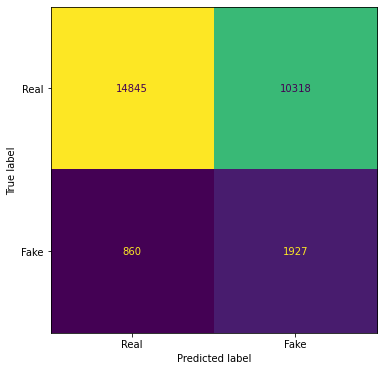

In [61]:
fig , ax = plt.subplots(figsize=(8,6))
plot_confusion_matrix(final_log_eng_model,X_test,y_test,display_labels=['Real','Fake'],colorbar=False,ax=ax,values_format='d');

In [62]:
functions.metrics(y_test,final_log_eng_model.predict(X_test))

Recall Score: 0.6914244707570865
Precision Score: 0.1573703552470396
Accuracy Score:0.6000715563506261
F1 Score: 0.25638637573177225
Confusion Matrix: 
[[14845 10318]
 [  860  1927]]


In [63]:
classifier = final_log_eng_model.named_steps['LR']
vals = sorted(classifier.coef_[0],reverse=True)


In [64]:
file = open('data/scraped_data/Broaddus_df','rb')
df_Broaddus = pickle.load(file)
file.close()

file = open('data/scraped_data/BonTemps_df','rb')
df_BonTemps = pickle.load(file)
file.close()

file = open('data/scraped_data/ruffinos_df','rb')
df_ruffinos = pickle.load(file)
file.close()

file = open('data/scraped_data/social_df','rb')
df_social = pickle.load(file)
file.close()

In [65]:
scraped_df = pd.concat([df_Broaddus,df_BonTemps,df_ruffinos,df_social],ignore_index=True)

In [66]:
file = open('data/scraped_data/BonTemps_NR_review','rb')
df_nr_bontemps = pickle.load(file)
file.close()

file = open('data/scraped_data/broaddus_NR_review','rb')
df_nr_broaddus = pickle.load(file)
file.close()

file = open('data/scraped_data/ruffino_NR_reviews','rb')
df_nr_ruffino = pickle.load(file)
file.close()


In [68]:
nr_scraped = pd.concat([df_nr_bontemps, df_nr_broaddus,df_nr_ruffino])
scraped_reviews_all = pd.concat([nr_scraped,scraped_df],ignore_index=True)

In [95]:
scraped_test = functions.transform(scraped_reviews_all,'review')

In [97]:
test = functions.test_df(scraped_test,'review')

In [72]:
final_log_eng_model.fit(X_train,y_train)

Pipeline(steps=[('tfidf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf1',
                                                  TfidfVectorizer(stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                              'you',
                                                                              "you'

In [73]:
y_real_preds = final_log_eng_model.predict(test)

In [74]:
scraped_reviews_all['Label'] = pd.Series(y_real_preds)

In [75]:
scraped_reviews_all

,review,gone,name,Label
0,Went based on reviews (4 1/2 stars) and I just...,,NaN,1
1,This has to be one of the worst restaurants I ...,,NaN,1
2,For starters some other guests who were dining...,,NaN,1
3,"One star was earned for the clean, casual surr...",,NaN,0
4,Im not a huge fan of this place. Their chicken...,,NaN,1
...,...,...,...,...
1814,I was hoping for a lot more oomph in the food ...,,Social Southern Table & Bar,1
1815,I have been here twice and I must say the food...,,Social Southern Table & Bar,1
1816,Disclaimer: My choice in this place is not a r...,,Social Southern Table & Bar,0
1817,Incredibly disappointing. My boyfriend and I w...,,Social Southern Table & Bar,0
